# Use `Lale`, `AIF360` and `DisparateImpactRemover` to mitigate bias for credit risk AutoAI model

This notebook contains the steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning service. It introduces commands for bias detecting and mitigation performed with `lale.lib.aif360` module. 

Some familiarity with Python is helpful. This notebook uses Python 3.11.

**NOTE:** The notebook is a continuation for sample notebook: <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a>. 

## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Load historical experiment](#definition)
3. [Pipeline bias detection and mitigation](#bias)
5. [Deployment and score](#scoring)
6. [Clean up](#cleanup)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

If you are not familiar with <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> and AutoAI experiments please read more about it in the sample notebook: <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a>. 

### Install and import the `ibm-watsonx-ai`, `lale` ,`aif360` and dependencies.
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget
!pip install "scikit-learn==1.3.0" | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U 'lale[fairness]>=0.8.2,<0.9' | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.  


**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below


In [4]:
space_id = 'PASTE YOUR SPACE ID HERE'

In [ ]:
client.spaces.list(limit=10)

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## 2. Load historical experiment

Initialiaze AutoAI experiment with Watson Machine Learning credentials and space.  

In [6]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

List all previous AutoAI experiment runs named `'Credit Risk Prediction and bias detection - AutoAI'` which was run in sample notebook <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a>. 

**NOTE:** If you don't have any experiment listed below please run the <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a> notebook first and then continue running the current notebook. 

In [7]:
autoai_experiment_name = 'Credit Risk Prediction and bias detection - AutoAI'

historical_experiments = experiment.runs(filter=autoai_experiment_name).list()
historical_experiments

timestamp                                run_id      state  \
0  2024-03-04T14:53:52.090Z  f1f0985c-b672-43cc-b7ac-9915a9faf756  completed   
1  2024-03-04T14:35:52.851Z  b68fd7dd-466d-4f6c-b021-a31128cd8702  completed   
2  2024-03-04T14:30:08.209Z  d3dda974-09ef-4331-aac9-af782af9d1cb  completed   
3  2024-03-04T14:22:38.587Z  8e1d5ffc-2804-4f21-8e11-2c0339365493  completed   

                        auto_pipeline_optimizer name  
0  Credit Risk Prediction and bias detection - Au...  
1  Credit Risk Prediction and bias detection - Au...  
2  Credit Risk Prediction and bias detection - Au...  
3  Credit Risk Prediction and bias detection - Au...

Load last experiment run to variable `pipeline_optimizer`.

In [16]:
run_id = historical_experiments.run_id[0]

pipeline_optimizer= experiment.runs.get_optimizer(run_id)

In [17]:
summary = pipeline_optimizer.summary()
summary

Enhancements      Estimator  \
Pipeline Name                                
Pipeline_1                   XGBClassifier   
Pipeline_2              HPO  XGBClassifier   
Pipeline_3          HPO, FE  XGBClassifier   
Pipeline_4     HPO, FE, HPO  XGBClassifier   

               training_accuracy_and_disparate_impact_(optimized)  \
Pipeline Name                                                       
Pipeline_1                                              0.667532    
Pipeline_2                                              0.667532    
Pipeline_3                                              0.682192    
Pipeline_4                                              0.682192    

               training_disparate_impact_Sex  training_roc_auc  \
Pipeline Name                                                    
Pipeline_1                          1.015940          0.845932   
Pipeline_2                          1.015940          0.845932   
Pipeline_3                          0.995254          0.834581   
Pipeline_4                          0.995254          0.834581   

               holdout_disparate_impact_Sex  holdout_average_precision  \
Pipeline Name                                                            
Pipeline_1                         1.020848                   0.480271   
Pipeline_2                         1.020848                   0.480271   
Pipeline_3                         1.050629                   0.481398   
Pipeline_4                         1.050629                   0.481398   

               holdout_log_loss  holdout_roc_auc  training_disparate_impact  \
Pipeline Name                                                                 
Pipeline_1             0.416678         0.858082                   1.847405   
Pipeline_2             0.416678         0.858082                   1.847405   
Pipeline_3             0.423934         0.853771                   1.759264   
Pipeline_4             0.423934         0.853771                   1.759264   

               ...  holdout_accuracy  holdout_balanced_accuracy  \
Pipeline Name  ...                                                
Pipeline_1     ...          0.811623                   0.755763   
Pipeline_2     ...          0.811623                   0.755763   
Pipeline_3     ...          0.819639                   0.767739   
Pipeline_4     ...          0.819639                   0.767739   

               training_recall  holdout_f1  training_accuracy  \
Pipeline Name                                                   
Pipeline_1            0.889599    0.867232           0.791658   
Pipeline_2            0.889599    0.867232           0.791658   
Pipeline_3            0.891613    0.872159           0.786303   
Pipeline_4            0.891613    0.872159           0.786303   

               holdout_disparate_impact  training_balanced_accuracy  \
Pipeline Name                                                         
Pipeline_1                     1.423913                     0.74354   
Pipeline_2                     1.423913                     0.74354   
Pipeline_3                     1.463687                     0.73456   
Pipeline_4                     1.463687                     0.73456   

               holdout_disparate_impact_Age  training_f1  \
Pipeline Name                                              
Pipeline_1                         1.436170     0.850221   
Pipeline_2                         1.436170     0.850221   
Pipeline_3                         1.456835     0.847253   
Pipeline_4                         1.456835     0.847253   

               training_disparate_impact_Age  
Pipeline Name                                 
Pipeline_1                          2.307181  
Pipeline_2                          2.307181  
Pipeline_3                          2.435183  
Pipeline_4                          2.435183  

[4 rows x 26 columns]

### Get selected pipeline model

Download pipeline model object from the AutoAI training job.

In [18]:
best_pipeline = pipeline_optimizer.get_pipeline()

### Get Credit Risk dataset from experiment configuration. 

In [19]:
X_train, X_holdout, y_train, y_holdout = pipeline_optimizer.get_data_connections()[0].read(with_holdout_split=True)
X_holdout.head()

CheckingStatus  LoanDuration           CreditHistory LoanPurpose  \
13         0_to_200            29    credits_paid_to_date   furniture   
31      no_checking            26  prior_payments_delayed  appliances   
3673         less_0            20    credits_paid_to_date  retraining   
3611    no_checking            25  prior_payments_delayed    car_used   
433     greater_200            34  prior_payments_delayed   furniture   

      LoanAmount ExistingSavings EmploymentDuration  InstallmentPercent  \
13          3705        less_100             less_1                   3   
31          4391     500_to_1000          greater_7                   4   
3673        4683        less_100             4_to_7                   2   
3611        5426     500_to_1000             4_to_7                   4   
433         5470      100_to_500             4_to_7                   4   

         Sex  OthersOnLoan  CurrentResidenceDuration       OwnsProperty  Age  \
13    female  co-applicant                         3          car_other   44   
31    female          none                         3          car_other   39   
3673    male          none                         1  savings_insurance   46   
3611    male          none                         3          car_other   41   
433     male          none                         4          car_other   33   

     InstallmentPlans Housing  ExistingCreditsCount        Job  Dependents  \
13               none     own                     1    skilled           1   
31             stores     own                     2  unskilled           2   
3673           stores    free                     1    skilled           1   
3611             none     own                     1    skilled           1   
433              none     own                     2    skilled           1   

     Telephone ForeignWorker  
13        none           yes  
31         yes           yes  
3673       yes           yes  
3611      none           yes  
433       none            no

<a id="bias"></a>
## 3. Bias detection and mitigation

The `fairness_info` dictionary contains some fairness-related metadata. The favorable and unfavorable label are values of the target class column that indicate whether the loan was granted or denied. A protected attribute is a feature that partitions the population into groups whose outcome should have parity. The credit-risk dataset has two protected attribute columns, sex and age. Each prottected attributes has monitored and reference group.


In [20]:
fairness_info = pipeline_optimizer.get_params()['fairness_info']
fairness_info

{'favorable_labels': ['No Risk'],
 'protected_attributes': [{'feature': 'Sex',
   'monitored_group': ['female'],
   'reference_group': ['male']},
  {'feature': 'Age',
   'monitored_group': [[18, 25]],
   'reference_group': [[26, 75]]}],
 'unfavorable_labels': ['Risk']}

### Calculate fairness metrics

We will calculate some model metrics. Accuracy describes how accurate is the model according to dataset. 
Disparate impact is defined by comparing outcomes between a privileged group and an unprivileged group, 
so it needs to check the protected attribute to determine group membership for the sample record at hand. The closer to 1 is the value of disparate impact the less biased is the model. 
The third calculated metric takes the disparate impact into account along with accuracy. The best value of the score is 1.0.

In [21]:
import sklearn.metrics
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact

accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_pipeline, X_holdout, y_holdout):.1%}')

disparate_impact_scorer = disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(best_pipeline, X_holdout, y_holdout):.2f}')

combined_scorer = accuracy_and_disparate_impact(**fairness_info)
print(f'accuracy and disparate impact metric {combined_scorer(best_pipeline, X_holdout, y_holdout):.2f}')

accuracy 81.2%
disparate impact 1.42
accuracy and disparate impact metric 0.76


## Refinery with lale

In this section we will use `DisparateImpactRemover` algorithm for mitigating fairness problems from `lale.lib.aif360` module. It modifies the features that are not the protected attribute in such a way that it is hard to predict the protected attribute from them. This algorithm has a hyperparameter `repair_level` that we will tune with hyperparameter optimization.

In [22]:
from lale.lib.aif360 import DisparateImpactRemover
from lale.pretty_print import ipython_display

ipython_display(DisparateImpactRemover.hyperparam_schema('repair_level'))

```python
{
    "description": "Repair amount from 0 = none to 1 = full.",
    "type": "number",
    "minimum": 0,
    "maximum": 1,
    "default": 1,
}
```

### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

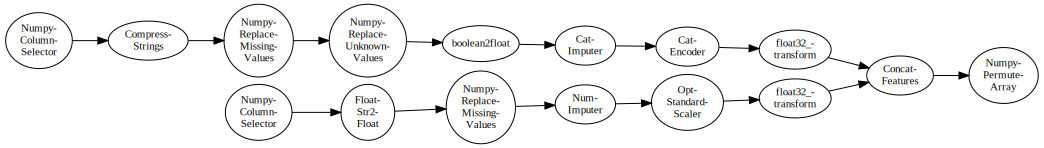

In [23]:
prefix = best_pipeline.remove_last().freeze_trainable()
prefix.visualize()

Initialize the `DisparateImpactRemover` with fairness configuration and pipeline without final estimator and add a new final step, which consists of a choice of two estimators. In this code, `|` is the or combinator (algorithmic choice). It defines a search space for another optimizer run.

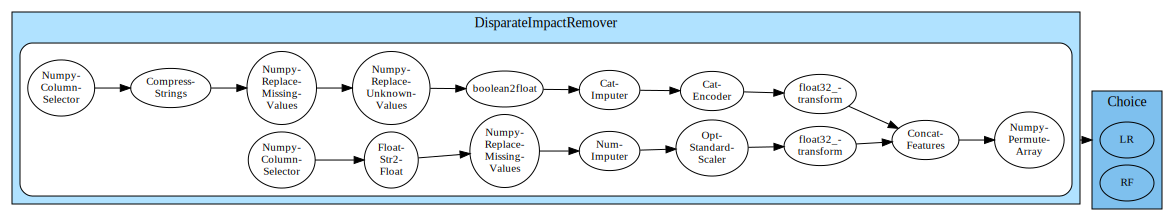

In [24]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from lale.operator_wrapper import wrap_imported_operators
wrap_imported_operators()

di_remover = DisparateImpactRemover(**fairness_info, preparation=prefix)
planned_fairer = di_remover >> (LR | RF)
planned_fairer.visualize()

Fairness metrics can be more unstable than accuracy, because they depend not just on the distribution of labels, but also on the distribution of privileged and unprivileged groups as defined by the protected attributes. In AI Automation, k-fold cross validation helps reduce overfitting. To get more stable results, we will stratify these k folds by both labels and groups with `FairStratifiedKFold` class.

In [25]:
from lale.lib.aif360 import FairStratifiedKFold

fair_cv = FairStratifiedKFold(**fairness_info, n_splits=3)

### Pipeline training

To automatically select the algorithm and tune its hyperparameters we use `auto_configure` method of lale pipeline. The combined metric `accuracy_and_disparate_impact` is used as scoring metric in evaluation process.   

In [ ]:
from lale.lib.lale import Hyperopt

trained_fairer = planned_fairer.auto_configure(
    X_train, y_train, optimizer=Hyperopt, cv=fair_cv,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

#### Results 

Visualize the final pipeline and calculate its metrics.  

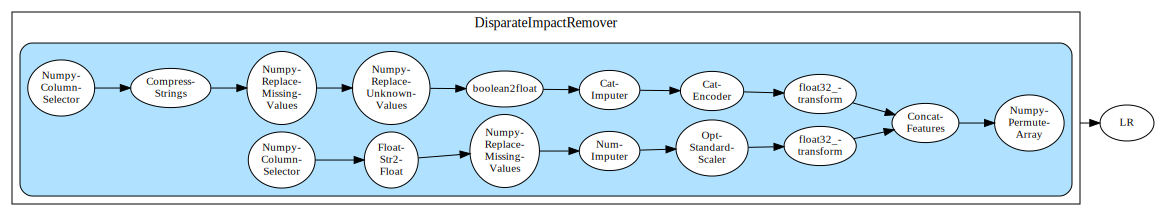

In [39]:
trained_fairer.visualize()

In [40]:
print(f'accuracy {accuracy_scorer(trained_fairer, X_holdout, y_holdout):.1%}')
print(f'disparate impact {disparate_impact_scorer(trained_fairer, X_holdout, y_holdout):.2f}')
print(f'accuracy and disparate impact metric {combined_scorer(trained_fairer, X_holdout, y_holdout):.2f}')


accuracy 66.5%
disparate impact 1.00
accuracy and disparate impact metric 0.83


**Summary:** As result of the described steps we received unbiased pipeline model based on disparate impact value, however the accuracy of the model decreased from 70% to 66%.

<a id="scoring"></a>
## 5. Deploy and Score
In this section you will learn how to deploy and score Lale pipeline model using WML instance.

### Store the model

In [28]:
model_props = {
    client.repository.ModelMetaNames.NAME: "Fairer AutoAI model"
    
}
feature_vector = list(X_train.columns)

In [30]:
published_model = client.repository.store_model(
    model=best_pipeline.export_to_sklearn_pipeline(), 
    meta_props=model_props,
    training_id=run_id
)

In [31]:
published_model_id = client.repository.get_model_id(published_model)

### Deployment creation

In [32]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of fairer model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'c9748e9e-e2e2-4a69-9f81-71e506d66a03' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ce74c4fc-2f81-4aaf-adbe-2fd9683db17e'
------------------------------------------------------------------------------------------------




In [33]:
deployment_id = client.deployments.get_id(created_deployment)

#### Deployment scoring 

You need to pass scoring values as input data if the deployed model. Use `client.deployments.score()` method to get predictions from deployed model. 

In [34]:
values = X_holdout.values

scoring_payload = {
    "input_data": [{
        'values': values[:5]
    }]
}

In [35]:
predictions = client.deployments.score(deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.6876538991928101, 0.31234613060951233]],
    ['Risk', [0.3356795907020569, 0.6643204092979431]],
    ['No Risk', [0.9083482027053833, 0.0916517898440361]],
    ['No Risk', [0.7679007649421692, 0.23209922015666962]],
    ['No Risk', [0.7194289565086365, 0.2805710434913635]]]}]}

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook!.

Check out used packeges domuntations:
- `ibm-watsonx-ai` [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)
- `lale`: https://github.com/IBM/lale
- `aif360`: https://aif360.mybluemix.net/

### Authors 

**Dorota Lączak**, software engineer in Watson Machine Learning at IBM

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning.

Copyright © 2022-2024 IBM. This notebook and its source code are released under the terms of the MIT License.